# 14.3. Resolving dependencies in a directed acyclic graph with a topological sort

In [1]:
import io
import json
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = ('https://github.com/ipython-books/'
       'cookbook-2nd-data/blob/master/'
       'react.graphml?raw=true')
f = io.BytesIO(requests.get(url).content)
graph = nx.read_graphml(f)

In [3]:
graph

In [4]:
len(graph.nodes), len(graph.edges)

(16, 20)

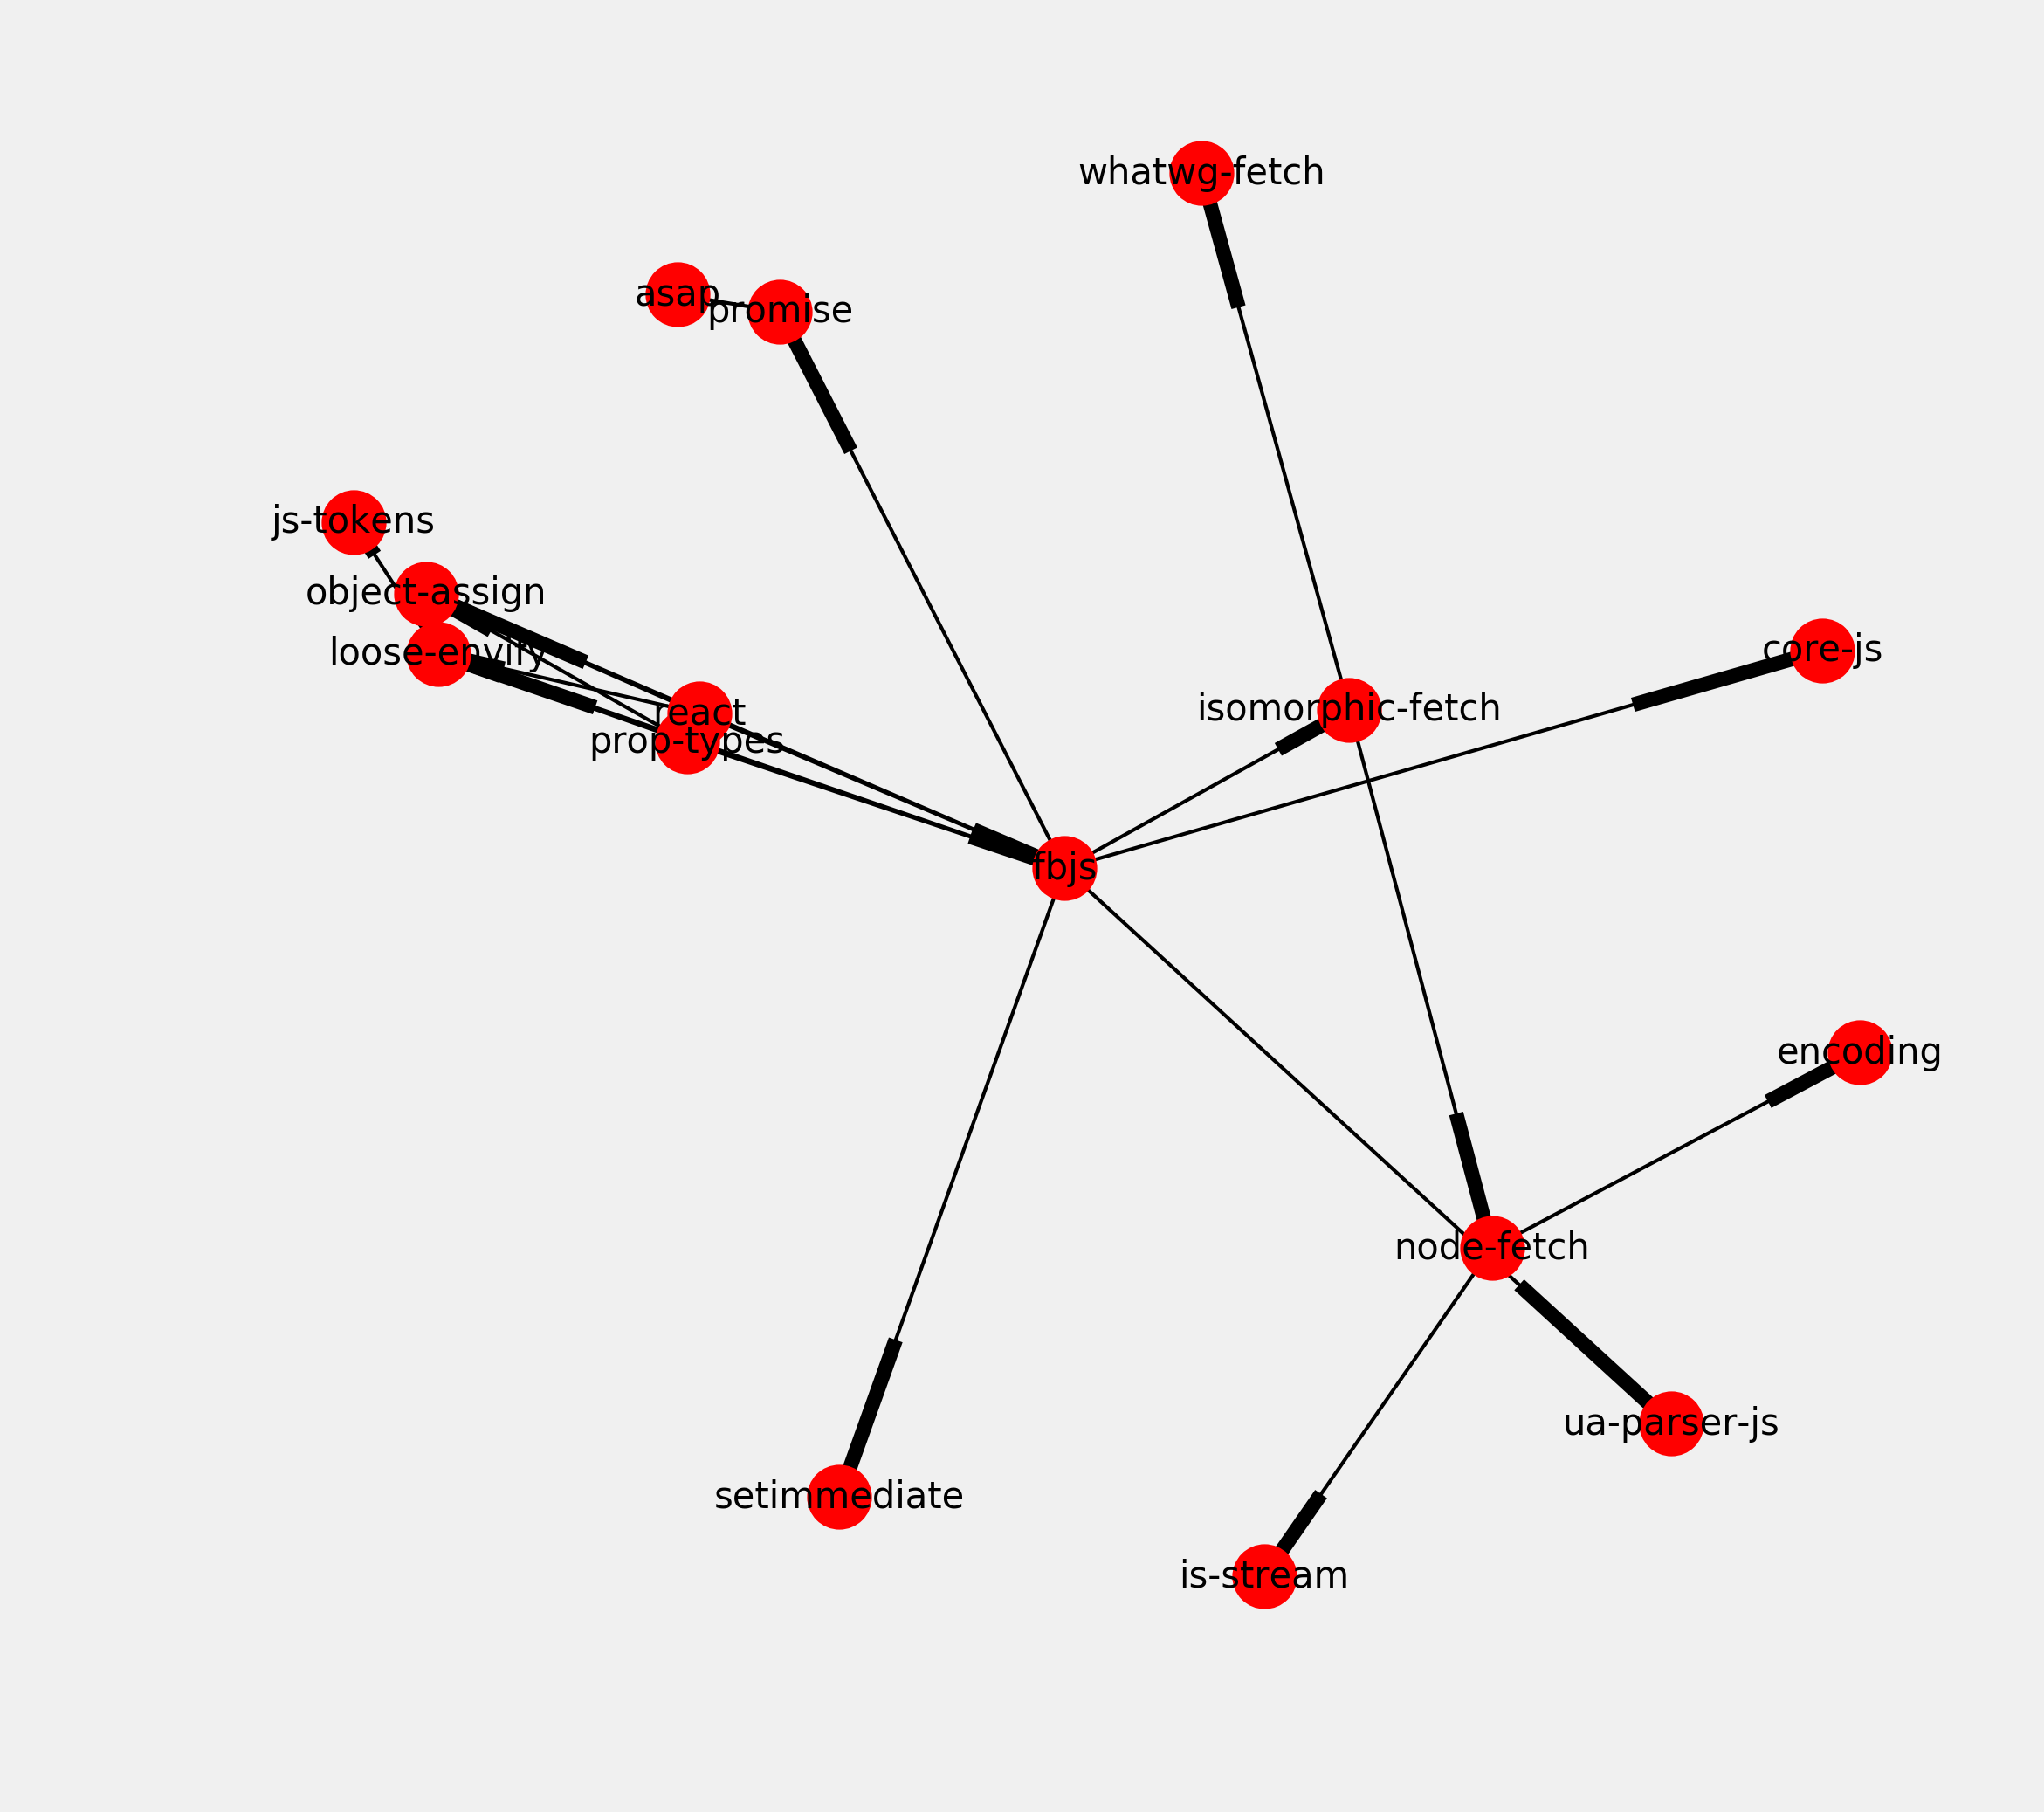

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(graph, ax=ax, font_size=10)
ax.set_axis_off()

In [6]:
nx.is_directed_acyclic_graph(graph)

True

In [7]:
ts = list(nx.topological_sort(graph))
ts

['react',
 'prop-types',
 'fbjs',
 'ua-parser-js',
 'setimmediate',
 'promise',
 'asap',
 'object-assign',
 'loose-envify',
 'js-tokens',
 'isomorphic-fetch',
 'whatwg-fetch',
 'node-fetch',
 'is-stream',
 'encoding',
 'core-js']

In [8]:
# Each node's color is the index of the node in the
# topological sort.
colors = [ts.index(node) for node in graph.nodes]

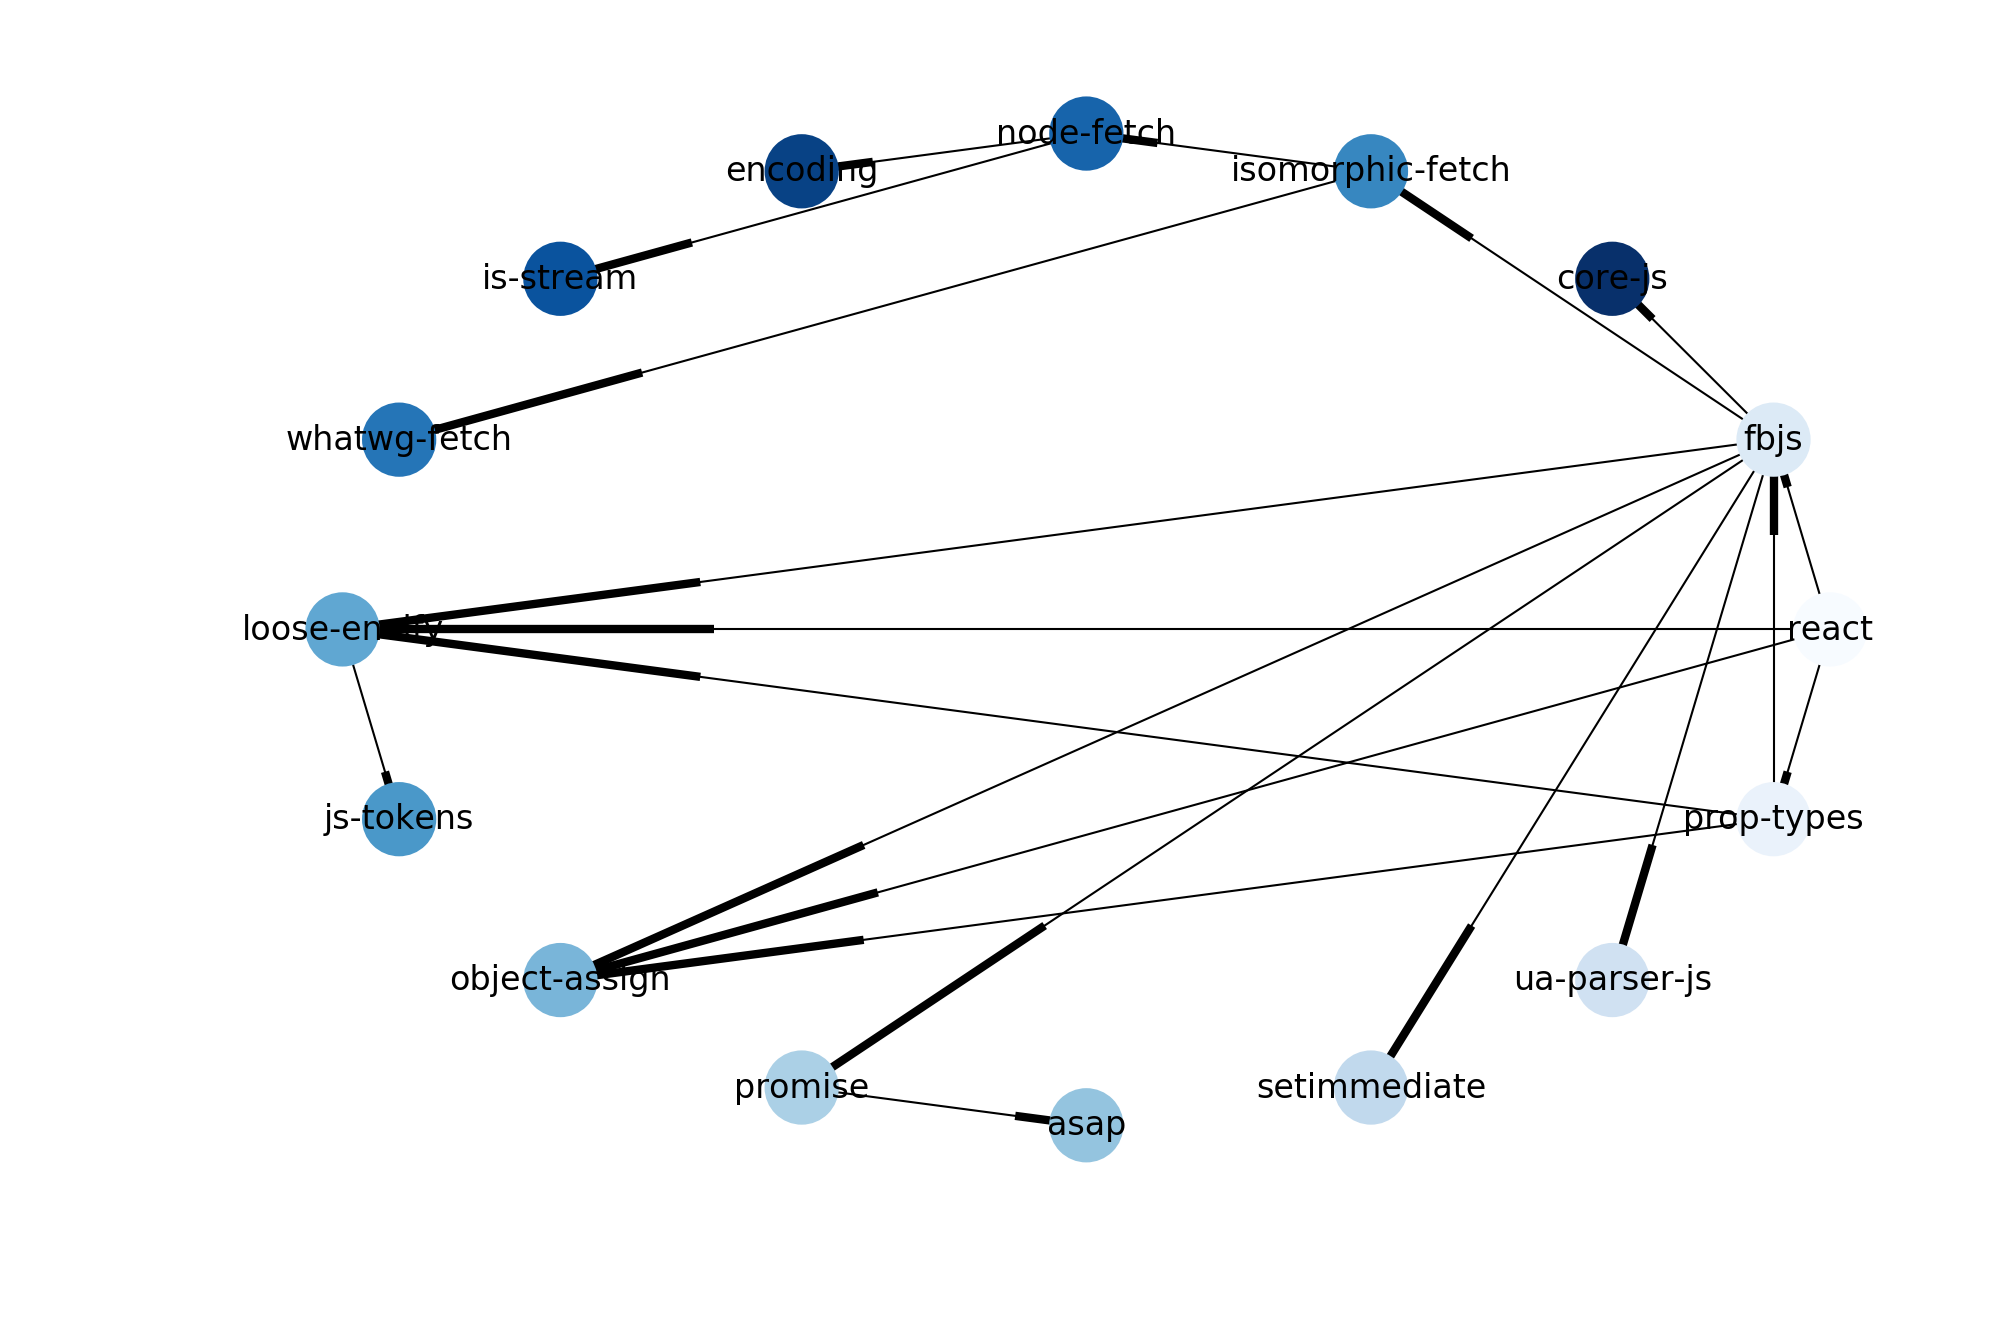

In [9]:
nx.draw_shell(graph,
              node_color=colors,
              cmap=plt.cm.Blues,
              font_size=8,
              width=.5
              )

In [10]:
from lxml.html import fromstring
import cssselect  # Need to do: pip install cssselect
from requests.packages import urllib3

urllib3.disable_warnings()
fetched_packages = set()

def import_package_dependencies(graph, pkg_name,
                                max_depth=3, depth=0):
    if pkg_name in fetched_packages:
        return
    if depth > max_depth:
        return
    fetched_packages.add(pkg_name)
    url = f'https://www.npmjs.com/package/{pkg_name}'
    response = requests.get(url, verify=False)
    doc = fromstring(response.content)
    graph.add_node(pkg_name)
    for h3 in doc.cssselect('h3'):
        content = h3.text_content()
        if content.startswith('Dependencies'):
            for dep in h3.getnext().cssselect('a'):
                dep_name = dep.text_content()
                print('-' * depth * 2, dep_name)
                graph.add_node(dep_name)
                graph.add_edge(pkg_name, dep_name)
                import_package_dependencies(
                    graph,
                    dep_name,
                    depth=depth + 1
                )

graph = nx.DiGraph()
import_package_dependencies(graph, 'react')
nx.write_graphml(graph, 'react.graphml')